In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

current_directory = os.getcwd()
print(current_directory)


/home/jolivera/Documents/CloudSkin/cloudskin-learning-plane/learning-plane/app/preprocessing


In [2]:


file_path = "/home/jolivera/Documents/CloudSkin/cloudskin-learning-plane/learning-plane/data/archive/preprocessed_data_2024-05-16 14:45:00.csv"
# csv_files = [file for file in os.listdir(file_path) if file.endswith(".csv")]

combined_df = pd.read_csv(file_path,sep=';')

In [47]:


file_path = "/home/jolivera/Downloads/promcsv/16.05"
csv_files = [file for file in os.listdir(file_path) if file.endswith(".csv")]

dfs = []
for file in csv_files:
    file_p = os.path.join(file_path, file)
    df = pd.read_csv(file_p,sep=';')
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)


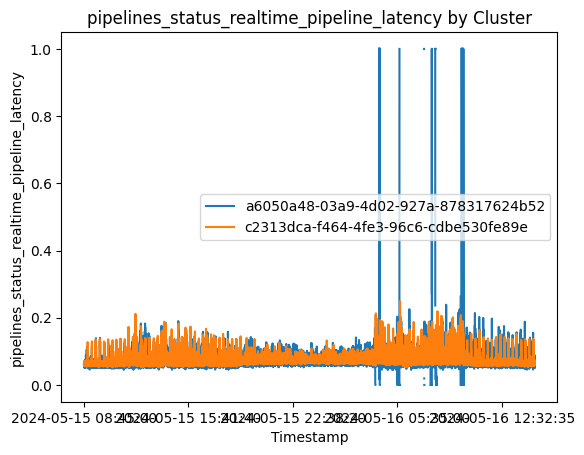

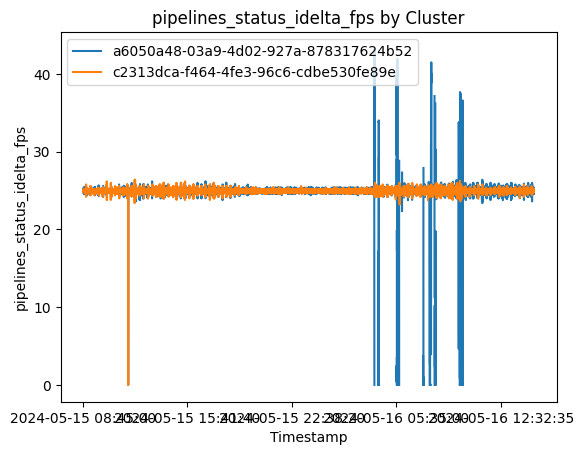

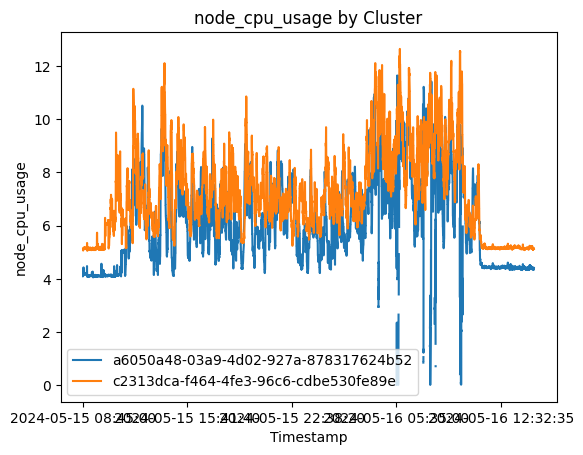

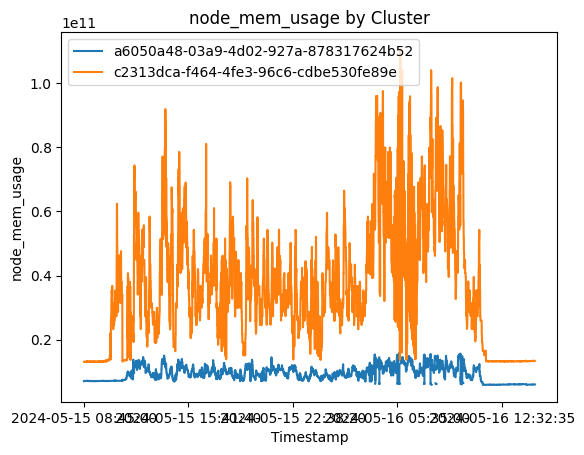

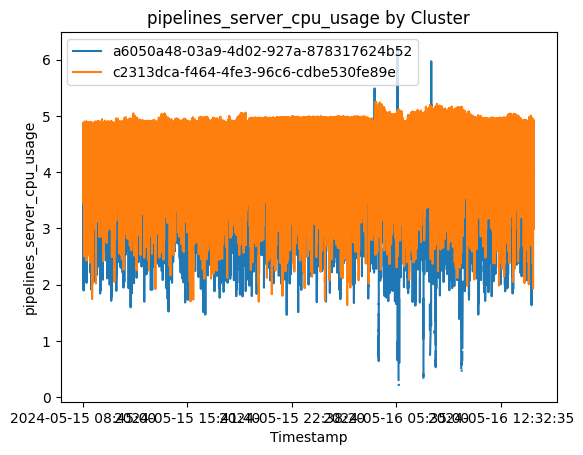

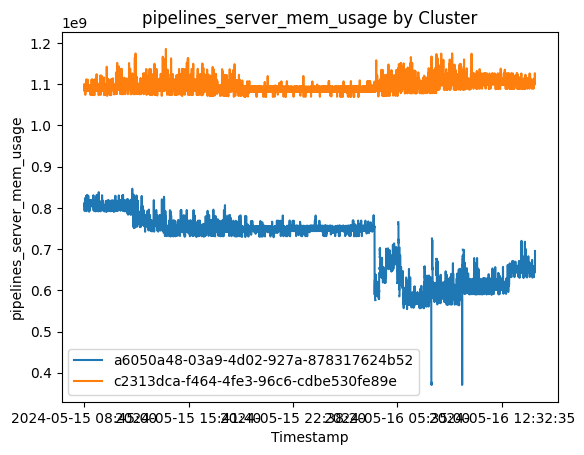

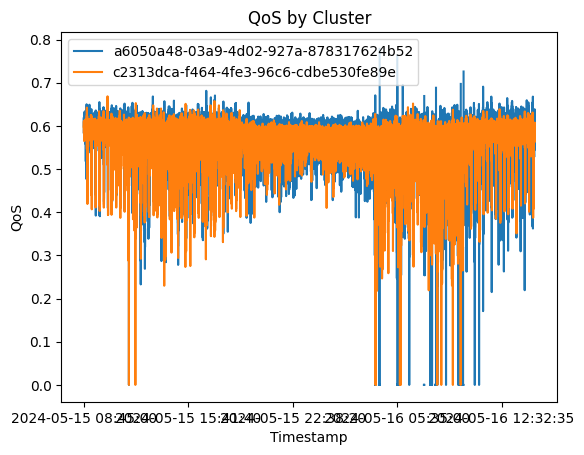

In [6]:
# Plot for each feature
features = ["pipelines_status_realtime_pipeline_latency",
            "pipelines_status_idelta_fps",
            "node_cpu_usage",
            "node_mem_usage",
            "pipelines_server_cpu_usage",
            "pipelines_server_mem_usage",
            "QoS"]

for feature in features:
    # Pivot the DataFrame
    pivot_df = combined_df.pivot(index='timestamp', columns='cluster', values=feature)

    # Plot the pivoted DataFrame
    pivot_df.plot()
    # Set labels and title
    plt.xlabel('Timestamp')
    plt.ylabel(feature)
    plt.title(f'{feature} by Cluster')
    
    # Show legend
    plt.legend()
    
    # Show plot
    plt.show()

In [84]:
def calculate_fps(combined_df):
    data=[]

    for cluster in combined_df.cluster.unique():
        # Subset data for the current cluster
        df = combined_df[combined_df['cluster'] == cluster]
        # Calculate the difference with the previous row
        df['elapsed_time_diff'] = df['pipelines_status_elapsed_time'].diff()
        df['frame_count_diff'] = df['pipelines_status_frame_count'].diff()

        # Calculate the frame rate
        df['frame_rate'] = df['frame_count_diff'] / (df['elapsed_time_diff'])  # Convert elapsed time to seconds

        # Handle the first row which will have NaN values due to diff()
        df['frame_rate'].fillna(0, inplace=True)

        data.append(df)

    # Combine the dataframes
    df = pd.concat(data).reset_index(drop=True)
        
    # Drop intermediate columns
    df.drop(columns=['frame_count_diff', 'elapsed_time_diff','pipelines_status_idelta_fps'], inplace=True)
    df.rename(columns={'frame_rate': 'pipelines_status_idelta_fps'}, inplace=True)
    return df

def clean_outliers_hardcoded(df,column,limit_value):

    # Adjust normalization based on conditions
    df[column] = df[column].clip(0,limit_value)
    
    return df


def normalize(series, min_value, max_value):
    return (series - min_value) / (max_value - min_value)    
    
def calculate_qos(data,min_fps,max_fps,min_lat,max_lat, fps_col, latency_col, w_fps=0.5, w_latency=0.5):

    # Normalize FPS and Latency
    data['Normalized FPS'] = normalize(data[fps_col], min_fps, max_fps).clip(0, 1)
    data['Normalized Latency'] = normalize(data[latency_col], min_lat, max_lat).clip(0, 1)
    
    # Calculate QoS
    data['QoS'] = (w_fps * data['Normalized FPS']) + (w_latency * (1 - data['Normalized Latency']))
    data['QoS'] = data['QoS'].clip(0, 1)  # Ensure QoS is within [0, 1]

    # Adjust normalization based on conditions
    data['QoS'] = data.apply(lambda row: 0 if row[fps_col] > max_fps or row[fps_col] < min_fps else row['QoS'], axis=1)
    data['QoS'] = data.apply(lambda row: 0 if row[latency_col] > max_lat or row[latency_col] < min_lat else row['QoS'], axis=1)
        
    # Drop intermediate columns
    data.drop(columns=['Normalized FPS', 'Normalized Latency'], inplace=True)
    return data


/tmp/ipykernel_531343/2137809254.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elapsed_time_diff'] = df['pipelines_status_elapsed_time'].diff()
/tmp/ipykernel_531343/2137809254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['frame_count_diff'] = df['pipelines_status_frame_count'].diff()
/tmp/ipykernel_531343/2137809254.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

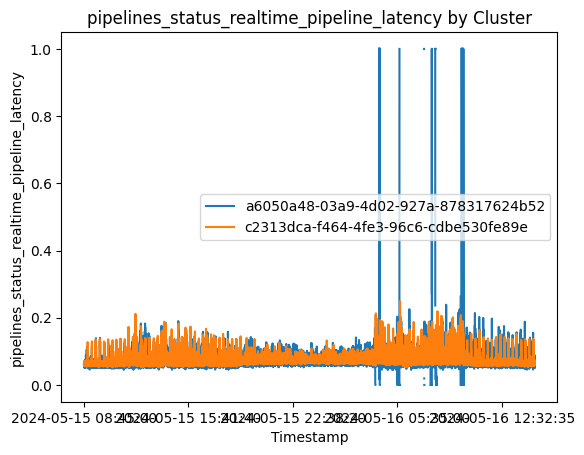

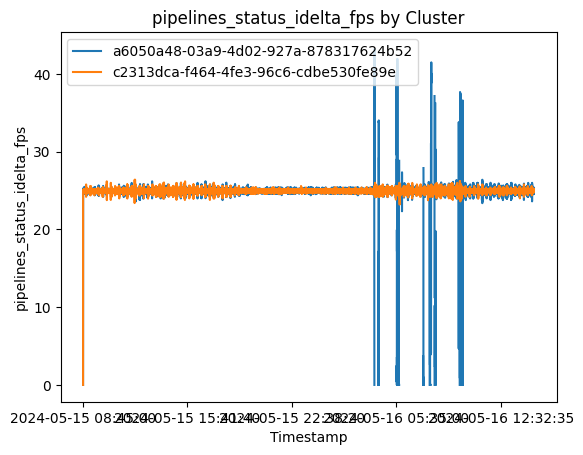

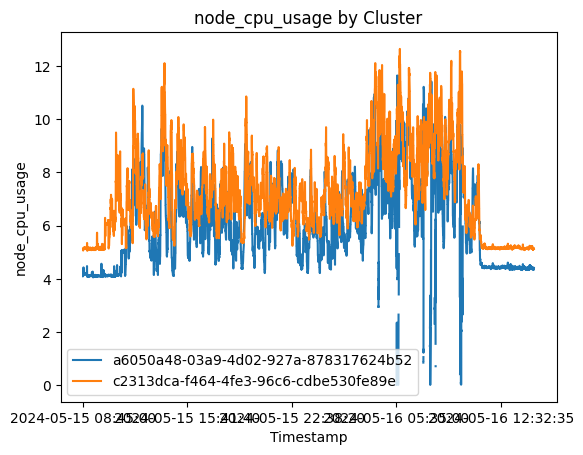

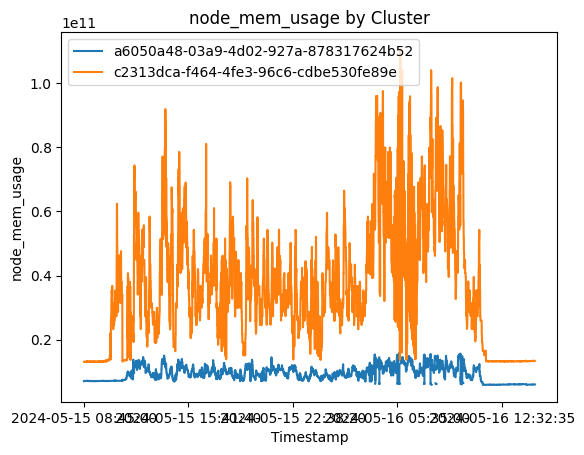

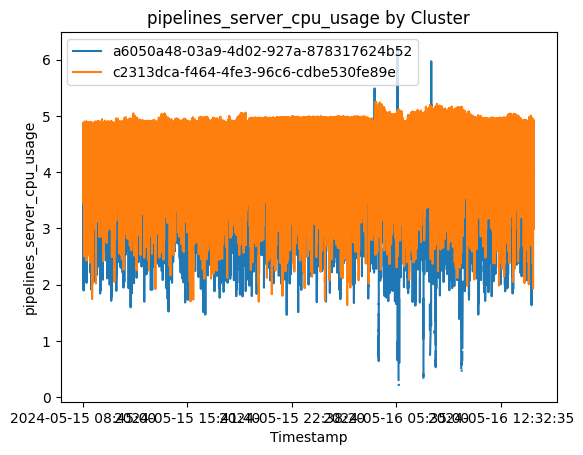

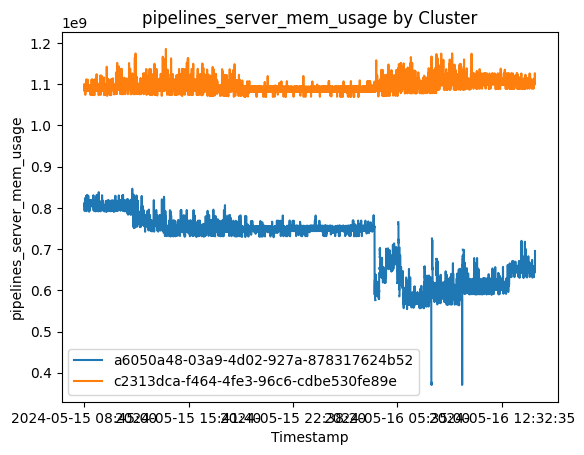

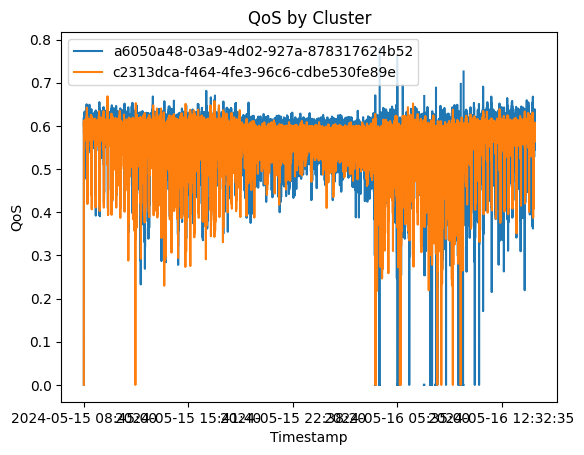

In [85]:
df=calculate_fps(combined_df)
df=clean_outliers_hardcoded(df,'pipelines_status_realtime_pipeline_latency',1)
# Calculate QoS with equal weights
qos_data = calculate_qos(df,20,30,0.001,0.2, 'pipelines_status_idelta_fps', 'pipelines_status_realtime_pipeline_latency')
# Plot for each feature
features = ["pipelines_status_realtime_pipeline_latency",
            "pipelines_status_idelta_fps",
            "node_cpu_usage",
            "node_mem_usage",
            "pipelines_server_cpu_usage",
            "pipelines_server_mem_usage",
            "QoS"]

for feature in features:
    # Pivot the DataFrame
    pivot_df = qos_data.pivot(index='timestamp', columns='cluster', values=feature)

    # Plot the pivoted DataFrame
    pivot_df.plot()
    # Set labels and title
    plt.xlabel('Timestamp')
    plt.ylabel(feature)
    plt.title(f'{feature} by Cluster')
    
    # Show legend
    plt.legend()
    
    # Show plot
    plt.show()